### Goal
- Input: RGB image.
- Teacher: Depth Anything V2 → predicts a high-quality depth map.
- Student: A smaller, faster model → learns to mimic the teacher’s depth map predictions.

In [5]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
import os

class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, depth_maps_dir, transform=None):
        self.images_dir = images_dir
        self.depth_maps_dir = depth_maps_dir
        self.transform = transform
        
        self.images_files = sorted(os.listdir(images_dir))
        self.depth_maps_files = sorted(os.listdir(depth_maps_dir))
        
    def __len__(self):
        return len(self.images_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images_files[idx])
        depth_map_path = os.path.join(self.depth_maps_dir, self.depth_maps_files[idx])
        
        image = plt.imread(image_path)
        depth_map = plt.imread(depth_map_path)[:,:,0]
        
        if self.transform:
            image = self.transform(image)
            depth_map = self.transform(depth_map)

        return image, image_path, depth_map, depth_map_path

Text(0.5, 1.0, 'depth_map_path: data/depth_data/depth_maps/screenshot_1751992957.256014.png')

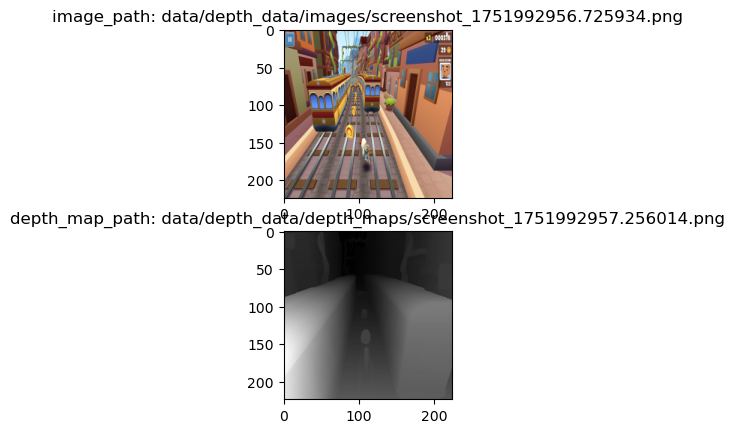

In [20]:
dataset = DepthDataset(
    images_dir='data/depth_data/images',
    depth_maps_dir='data/depth_data/depth_maps',
    transform=ToTensor(),
)

image, image_path, depth_map, depth_map_path = dataset.__getitem__(10)

plt.subplot(2, 1, 1)
plt.imshow(image.permute(1, 2, 0))  # if tensor
plt.title("image_path: " + image_path)

plt.subplot(2, 1, 2)
plt.imshow(depth_map.squeeze(), cmap='gray')  # if tensor
plt.title("depth_map_path: " + depth_map_path)
